In [6]:
import pandas as pd
import numpy as np
from IPython.display import HTML

def generate_traffic_data():
    """Génère des données de trafic pour 280000 requêtes sur 20 heures"""
    # Définir les coefficients pour modéliser un trafic réaliste avec des pics
    hourly_factors = [
        0.02, 0.01, 0.005, 0.01, 0.02,  # 0h-5h: très faible activité
        0.04, 0.08, 0.09, 0.11, 0.10,   # 5h-10h: montée progressive, premier pic
        0.07, 0.06, 0.08, 0.09, 0.10,   # 10h-15h: milieu de journée
        0.09, 0.07, 0.05, 0.03, 0.02    # 15h-20h: descente progressive
    ]
    
    # Normaliser les facteurs pour qu'ils somment à 1
    normalized_factors = [f / sum(hourly_factors) for f in hourly_factors]
    
    # Générer les données
    total_requests = 280000
    data = []
    cumulative_requests = 0
    
    for hour in range(20):
        base_requests = round(total_requests * normalized_factors[hour])
        
        for minute in range(0, 60, 10):
            # Variation aléatoire pour les 10 minutes (-30% à +30%)
            random_factor = 0.7 + np.random.random() * 0.6
            requests_count = round((base_requests / 6) * random_factor)
            
            cumulative_requests += requests_count
            
            data.append({
                'time': f"{hour:02d}:{minute:02d}",
                'hour': hour,
                'requests': requests_count,
                'cumulative_requests': cumulative_requests,
                'requests_per_second': round(requests_count / 600)
            })
    
    # Ajuster pour atteindre exactement 280000
    diff = total_requests - data[-1]['cumulative_requests']
    data[-1]['requests'] += diff
    data[-1]['cumulative_requests'] += diff
    
    return pd.DataFrame(data)

def create_hourly_data(df):
    """Agrège les données par heure"""
    hourly_data = []
    for hour in range(20):
        hour_df = df[df['hour'] == hour]
        hourly_requests = hour_df['requests'].sum()
        
        hourly_data.append({
            'hour': f"{hour:02d}:00",
            'requests': hourly_requests,
            'requests_per_second': round(hourly_requests / 3600)
        })
    
    return pd.DataFrame(hourly_data)

# Générer les données
traffic_df = generate_traffic_data()
hourly_df = create_hourly_data(traffic_df)

# Calculer les métriques
peak_hourly_traffic = hourly_df['requests'].max()
peak_hour = hourly_df.loc[hourly_df['requests'].idxmax(), 'hour']
peak_rps = traffic_df['requests_per_second'].max()
average_rps = round(280000 / (20 * 3600))

# Afficher des statistiques
print(f"Total des requêtes: 280,000")
print(f"Pic de trafic horaire: {peak_hourly_traffic:,} requêtes/heure à {peak_hour}")
print(f"Pic de trafic: {peak_rps} requêtes/seconde")
print(f"Moyenne: {average_rps} requêtes/seconde")

# Générer le HTML avec Plotly pour les visualisations
# Install plotly if not already installed
%pip install plotly

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Créer la figure avec deux sous-graphiques
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Distribution horaire des requêtes", "Trafic détaillé (req/sec)"),
    vertical_spacing=0.2
)

# Graphique à barres pour la distribution horaire
fig.add_trace(
    go.Bar(x=hourly_df['hour'], y=hourly_df['requests'], name="Requêtes par heure", marker_color='#8884d8'),
    row=1, col=1
)

# Ligne horizontale pour la moyenne horaire
fig.add_trace(
    go.Scatter(x=hourly_df['hour'], y=[280000/20]*len(hourly_df), 
               mode='lines', name="Moyenne horaire", 
               line=dict(color='#FF8042', dash='dash')),
    row=1, col=1
)

# Graphique linéaire pour les requêtes par seconde
fig.add_trace(
    go.Scatter(x=traffic_df['time'], y=traffic_df['requests_per_second'], 
               mode='lines', name="Requêtes par seconde", line=dict(color='#82ca9d')),
    row=2, col=1
)

# Ligne horizontale pour la moyenne par seconde
fig.add_trace(
    go.Scatter(x=traffic_df['time'], y=[average_rps]*len(traffic_df), 
               mode='lines', name="Moyenne par seconde", 
               line=dict(color='#FF8042', dash='dash')),
    row=2, col=1
)

# Mise en page et style
fig.update_layout(
    height=800,
    width=1000,
    title_text="Simulation de trafic - 280 000 requêtes sur 20 heures",
    template="plotly_white"
)

# Mettre à jour les axes X pour n'afficher qu'un sous-ensemble de valeurs
fig.update_xaxes(tickangle=45, row=2, col=1, tickmode='array', 
                 tickvals=traffic_df['time'][::12])  # Afficher environ toutes les 2 heures

# Afficher le graphique dans le notebook
fig.show()

# Créer un HTML pour les statistiques clés
stats_html = f"""
<div style="display: flex; margin-bottom: 20px;">
    <div style="flex: 1; background-color: #ebf5ff; padding: 15px; border-radius: 8px; margin-right: 10px;">
        <h3 style="margin-top: 0; font-size: 18px; font-weight: bold;">Pic de trafic</h3>
        <div style="font-size: 24px; font-weight: bold; color: #1a56db;">{peak_rps} req/sec</div>
        <div style="font-size: 14px; color: #6b7280;">Période de pointe: {peak_hour}</div>
    </div>
    
    <div style="flex: 1; background-color: #ecfdf5; padding: 15px; border-radius: 8px;">
        <h3 style="margin-top: 0; font-size: 18px; font-weight: bold;">Moyenne</h3>
        <div style="font-size: 24px; font-weight: bold; color: #047857;">{average_rps} req/sec</div>
        <div style="font-size: 14px; color: #6b7280;">Sur l'ensemble de la période</div>
    </div>
</div>

<div style="background-color: #f9fafb; padding: 15px; border-radius: 8px; margin-top: 20px;">
    <h3 style="margin-top: 0; font-size: 18px; font-weight: bold;">Implications pour le dimensionnement</h3>
    <ul style="padding-left: 20px;">
        <li>Votre application doit pouvoir gérer <strong>au moins {peak_rps} requêtes par seconde</strong> aux heures de pointe</li>
        <li>La moyenne de <strong>{average_rps} req/sec</strong> peut servir de base pour le dimensionnement mais avec une marge suffisante</li>
        <li>Considérez une capacité de <strong>{round(peak_rps * 1.5)} req/sec</strong> pour gérer les pics imprévus et assurer une bonne performance</li>
    </ul>
</div>
"""

HTML(stats_html)

Total des requêtes: 280,000
Pic de trafic horaire: 28,370 requêtes/heure à 14:00
Pic de trafic: 9 requêtes/seconde
Moyenne: 4 requêtes/seconde
  Using cached plotly-6.0.1-py3-none-any.whl.metadata (6.7 kB)
  Using cached narwhals-1.31.0-py3-none-any.whl.metadata (11 kB)
Using cached plotly-6.0.1-py3-none-any.whl (14.8 MB)
Using cached narwhals-1.31.0-py3-none-any.whl (313 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import json

# JE VEUX IMPORTER LE FICHIER JSON 9577_2024-12-11.json

# JE VEUX LIRE LE FICHIER JSON
fichier = "9577_2024-12-11.json"
f1 = open(fichier)
data = json.load(f1)
display(data)

{'circulation': {'numero': '9577',
  'date': '2024-12-10',
  'codeOperateur': '1187',
  'typeMode': 'FERRE'},
 'dessertes': [{'codeUIC': '87654321',
   'rang': '0',
   'rames': [{'voitures': [{'numero': '1',
       'places': [{'numero': '1',
         'classe': 'PREMIERE',
         'compartiment': '1',
         'niveau': 'SALLE_BASSE',
         'type': 'PLACE_ASSISE',
         'occupation': {'statut': 'LIBRE'}},
        {'numero': '2',
         'classe': 'SECONDE',
         'compartiment': '1',
         'niveau': 'SALLE_BASSE',
         'type': 'PLACE_ASSISE',
         'occupation': {'statut': 'OCCUPE', 'fluxMontant': True}},
        {'numero': '3',
         'classe': 'PREMIERE',
         'compartiment': '1',
         'niveau': 'SALLE_HAUTE',
         'type': 'PLACE_ASSISE',
         'occupation': {'statut': 'OCCUPE', 'fluxMontant': True}},
        {'numero': '4',
         'classe': 'PREMIERE',
         'compartiment': '1',
         'niveau': 'SALLE_HAUTE',
         'type': 'PLACE_ASSIS

In [4]:
# Importer le générateur (après avoir sauvegardé le script dans un fichier)
%run train_data_generator.py  # Ou importez-le si vous le transformez en module

# Générer un ensemble de données (5 trains)
train_data_list, stations = generate_train_dataset(
    num_trains=5,
    base_date="2025-04-01",
    output_folder="./data"
)

# Afficher les informations générées
print(f"Nombre de stations générées: {len(stations)}")
print(f"Nombre de trains générés: {len(train_data_list)}")

# Exemple d'accès aux données du premier train
train = train_data_list[0]
print(f"Train {train['circulation']['numero']}, Date: {train['circulation']['date']}")
print(f"Nombre de dessertes: {len(train['dessertes'])}")

Fichier de référentiel des stations généré: ./data\Référentiel_stations.json
Fichier JSON généré: ./data\92494_2025-04-07.json
Fichier JSON généré: ./data\13490_2025-04-07.json
Fichier JSON généré: ./data\28673_2025-04-04.json
Fichier JSON généré: ./data\88377_2025-04-02.json
Fichier JSON généré: ./data\50201_2025-04-01.json
Nombre de stations générées: 30
Nombre de trains générés: 5
Train 92494, Date: 2025-04-07
Nombre de dessertes: 8


In [1]:
import json
import random
import datetime
import os
import numpy as np
from typing import List, Dict, Any, Optional, Tuple, Union

def generate_train_timeseries(
    train_number: str,
    start_date: str,
    end_date: str,
    stations: List[Dict[str, str]],
    selected_stations: Optional[List[Dict[str, str]]] = None,
    num_coaches: int = 8,
    seats_per_coach: int = 10,
    base_occupation_rate: float = 0.3,
    seasonal_factor: float = 0.2,
    weekly_pattern: Optional[List[float]] = None,
    special_dates: Optional[Dict[str, float]] = None,
    output_folder: Optional[str] = None,
    verbose: bool = True
) -> List[Dict[str, Any]]:
    """
    Génère une série temporelle de données d'occupation d'un train au format JSON pour une période donnée.
    
    Args:
        train_number (str): Numéro du train
        start_date (str): Date de début au format YYYY-MM-DD
        end_date (str): Date de fin au format YYYY-MM-DD
        stations (List[Dict]): Liste complète des gares disponibles
        selected_stations (List[Dict], optional): Liste spécifique des gares desservies par ce train
        num_coaches (int): Nombre de voitures
        seats_per_coach (int): Nombre de sièges par voiture
        base_occupation_rate (float): Taux d'occupation de base (0-1)
        seasonal_factor (float): Amplitude des variations saisonnières (0-1)
        weekly_pattern (List[float], optional): Coefficient multiplicateur pour chaque jour de la semaine (lundi=0, dimanche=6)
        special_dates (Dict[str, float], optional): Dictionnaire de dates spéciales avec leur coefficient multiplicateur
        output_folder (str, optional): Dossier de sortie pour les fichiers JSON
        verbose (bool): Afficher les informations de progression
    
    Returns:
        List[Dict[str, Any]]: Liste des données générées pour chaque jour
    """
    # Convertir les dates en objets datetime
    start_date_obj = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date_obj = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    
    # Calculer le nombre de jours
    delta = end_date_obj - start_date_obj
    num_days = delta.days + 1
    
    if verbose:
        print(f"Génération de données pour {num_days} jours entre {start_date} et {end_date}")
    
    # Définir le motif hebdomadaire par défaut si non fourni
    # (coefficients pour lundi à dimanche - 1.0 = occupation moyenne)
    if weekly_pattern is None:
        # Occupation plus élevée le weekend et le vendredi
        weekly_pattern = [0.8, 0.75, 0.8, 0.9, 1.2, 1.3, 1.0]
    
    # Initialiser le dictionnaire des dates spéciales si non fourni
    if special_dates is None:
        special_dates = {}
        
        # Ajouter quelques jours fériés français avec une occupation plus élevée
        holidays = [
            (1, 1),    # Jour de l'An
            (5, 1),    # Fête du Travail
            (7, 14),   # Fête Nationale
            (8, 15),   # Assomption
            (11, 1),   # Toussaint
            (11, 11),  # Armistice
            (12, 25),  # Noël
        ]
        
        # Ajouter les jours fériés pour chaque année concernée
        current_year = start_date_obj.year
        end_year = end_date_obj.year
        
        for year in range(current_year, end_year + 1):
            for month, day in holidays:
                date_str = f"{year}-{month:02d}-{day:02d}"
                # Occupation plus élevée autour des jours fériés
                special_dates[date_str] = 1.5
                
                # Ajouter la veille et le lendemain avec des coefficients légèrement plus faibles
                day_before = (datetime.datetime.strptime(date_str, "%Y-%m-%d") - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
                day_after = (datetime.datetime.strptime(date_str, "%Y-%m-%d") + datetime.timedelta(days=1)).strftime("%Y-%m-%d")
                
                special_dates[day_before] = 1.4
                special_dates[day_after] = 1.3
        
        # Ajouter les périodes de vacances scolaires (approximativement)
        vacation_periods = [
            # Vacances d'hiver (2 semaines en février)
            (f"{current_year}-02-15", f"{current_year}-03-01", 1.4),
            # Vacances de printemps (2 semaines en avril)
            (f"{current_year}-04-15", f"{current_year}-04-30", 1.3),
            # Vacances d'été (juillet-août)
            (f"{current_year}-07-01", f"{current_year}-08-31", 1.6),
            # Vacances de la Toussaint (1 semaine fin octobre)
            (f"{current_year}-10-25", f"{current_year}-11-05", 1.3),
            # Vacances de Noël (2 semaines)
            (f"{current_year}-12-20", f"{current_year}-01-05", 1.5),
        ]
        
        # Ajouter les périodes de vacances
        for start_vac, end_vac, coef in vacation_periods:
            start_vac_obj = datetime.datetime.strptime(start_vac, "%Y-%m-%d")
            end_vac_obj = datetime.datetime.strptime(end_vac, "%Y-%m-%d")
            
            # Si la fin est en janvier de l'année suivante
            if end_vac_obj.year > start_vac_obj.year:
                end_vac_obj = datetime.datetime(start_vac_obj.year + 1, end_vac_obj.month, end_vac_obj.day)
            
            # Ajouter chaque jour de la période
            current_date = start_vac_obj
            while current_date <= end_vac_obj:
                date_str = current_date.strftime("%Y-%m-%d")
                # Éviter d'écraser les jours fériés qui ont déjà un coefficient
                if date_str not in special_dates:
                    special_dates[date_str] = coef
                current_date += datetime.timedelta(days=1)
    
    # Sélectionner les gares si elles ne sont pas déjà spécifiées
    if selected_stations is None:
        # Sélectionner un sous-ensemble de gares pour le parcours du train
        selected_stations = random.sample(stations, min(len(stations), random.randint(7, 12)))
    
    # Trier les gares pour créer un parcours logique
    selected_stations_with_rank = [(station, i) for i, station in enumerate(selected_stations)]
    
    # Liste pour stocker les données générées pour chaque jour
    all_data = []
    
    # Générer des données pour chaque jour
    current_date = start_date_obj
    day_counter = 0
    
    while current_date <= end_date_obj:
        date_str = current_date.strftime("%Y-%m-%d")
        day_of_week = current_date.weekday()  # 0 = lundi, 6 = dimanche
        
        # Calculer le taux d'occupation pour cette date spécifique
        
        # 1. Facteur saisonnier (variation sinusoïdale sur l'année)
        day_of_year = current_date.timetuple().tm_yday  # 1-366
        year_progress = day_of_year / 366  # 0-1
        # Sinusoïde avec maximum en été
        seasonal_offset = seasonal_factor * np.sin(2 * np.pi * (year_progress - 0.5))
        
        # 2. Facteur hebdomadaire
        weekly_factor = weekly_pattern[day_of_week]
        
        # 3. Facteur spécial pour les dates spécifiques (jours fériés, vacances, etc.)
        special_factor = special_dates.get(date_str, 1.0)
        
        # Calculer le taux d'occupation final (avec des limites)
        daily_occupation_rate = base_occupation_rate * (1 + seasonal_offset) * weekly_factor * special_factor
        daily_occupation_rate = max(0.1, min(0.9, daily_occupation_rate))  # Limiter entre 10% et 90%
        
        # Générer les données pour ce jour
        train_data = generate_train_data_for_day(
            train_number=train_number,
            date=date_str,
            selected_stations=selected_stations,
            selected_stations_with_rank=selected_stations_with_rank,
            num_coaches=num_coaches,
            seats_per_coach=seats_per_coach,
            occupation_rate=daily_occupation_rate,
            output_folder=output_folder
        )
        
        all_data.append(train_data)
        
        # Incrémenter le compteur et la date
        day_counter += 1
        current_date += datetime.timedelta(days=1)
        
        # Afficher la progression
        if verbose and day_counter % 30 == 0:
            print(f"Généré {day_counter}/{num_days} jours ({(day_counter/num_days*100):.1f}%)")
    
    if verbose:
        print(f"Génération terminée: {len(all_data)} jours de données générés")
    
    return all_data

def generate_train_data_for_day(
    train_number: str,
    date: str,
    selected_stations: List[Dict[str, str]],
    selected_stations_with_rank: List[Tuple[Dict[str, str], int]],
    num_coaches: int,
    seats_per_coach: int,
    occupation_rate: float,
    output_folder: Optional[str] = None
) -> Dict[str, Any]:
    """
    Génère des données d'occupation de train pour un jour spécifique.
    Version modifiée de generate_train_data pour être utilisée avec generate_train_timeseries.
    """
    # Créer la structure de base du document
    train_data = {
        "circulation": {
            "numero": train_number,
            "date": date,
            "codeOperateur": "1187",
            "typeMode": "FERRE"
        },
        "dessertes": []
    }
    
    # Liste pour suivre l'occupation de chaque siège tout au long du trajet
    seat_occupations = {}  # {(coach, seat): [(start_rang, end_rang), ...]}
    
    # Générer les dessertes (gares)
    for rank, (station, i) in enumerate(selected_stations_with_rank):
        desserte = {
            "codeUIC": station["codeUIC"],
            "rang": str(rank),
            "rames": [{
                "voitures": []
            }]
        }
        
        # Générer les voitures et sièges
        for coach in range(1, num_coaches + 1):
            voiture = {
                "numero": str(coach),
                "places": []
            }
            
            # Générer les sièges pour cette voiture
            for seat in range(1, seats_per_coach + 1):
                seat_id = (coach, seat)
                
                # Initialiser le suivi de l'occupation pour ce siège
                if seat_id not in seat_occupations:
                    seat_occupations[seat_id] = []
                
                # Déterminer si c'est un siège de première ou seconde classe
                classe = "PREMIERE" if coach <= (num_coaches // 3) else "SECONDE"
                
                # Déterminer le compartiment et le niveau
                compartiment = "1" if seat <= seats_per_coach // 2 else "2"
                niveau = "SALLE_BASSE" if seat % 2 == 1 else "SALLE_HAUTE"
                
                # Créer le siège de base avec occupation LIBRE par défaut
                place = {
                    "numero": str(seat),
                    "classe": classe,
                    "compartiment": compartiment,
                    "niveau": niveau,
                    "type": "PLACE_ASSISE",
                    "occupation": {
                        "statut": "LIBRE"
                    }
                }
                
                # Vérifier si le siège est déjà occupé par un segment existant
                is_occupied = False
                for start_rang, end_rang in seat_occupations[seat_id]:
                    if start_rang <= rank <= end_rang:
                        is_occupied = True
                        break
                
                # Si le siège n'est pas occupé, déterminer s'il doit être occupé à partir de cette gare
                if not is_occupied and rank < len(selected_stations_with_rank) - 1:
                    # Probabilité d'occupation plus élevée pour les premières classes et début du trajet
                    base_probability = occupation_rate
                    if classe == "PREMIERE":
                        base_probability *= 1.5
                    if rank < len(selected_stations_with_rank) // 3:
                        base_probability *= 1.3
                    
                    if random.random() < base_probability:
                        # Décider où le passager descendra
                        # Pour rendre les trajets plus réalistes, on favorise les trajets plus courts
                        # Calculer une longueur typique de trajet (en nombre de gares)
                        max_trip_length = min(5, len(selected_stations_with_rank) - rank - 1)
                        trip_length = min(
                            max_trip_length,
                            max(1, int(random.expovariate(1/2)))  # Distribution exponentielle avec moyenne de 2 gares
                        )
                        end_desserte_rank = min(rank + trip_length, len(selected_stations_with_rank) - 1)
                        
                        # Enregistrer l'occupation
                        seat_occupations[seat_id].append((rank, end_desserte_rank))
                        
                        # Marquer comme occupé avec fluxMontant
                        place["occupation"]["statut"] = "OCCUPE"
                        place["occupation"]["fluxMontant"] = True
                
                # Vérifier si un passager descend à cette desserte
                for start_rang, end_rang in seat_occupations[seat_id]:
                    if end_rang == rank:
                        place["occupation"]["fluxDescendant"] = True
                
                # Possibilité d'avoir un changement de voyageur (descente et montée à la même desserte)
                if (rank > 0 and rank < len(selected_stations_with_rank) - 1 and 
                    "fluxDescendant" in place["occupation"] and 
                    random.random() < 0.2):
                    
                    # Décider où le nouveau passager descendra
                    max_trip_length = min(5, len(selected_stations_with_rank) - rank - 1)
                    trip_length = min(
                        max_trip_length,
                        max(1, int(random.expovariate(1/2)))
                    )
                    end_desserte_rank = min(rank + trip_length, len(selected_stations_with_rank) - 1)
                    
                    # Enregistrer l'occupation
                    seat_occupations[seat_id].append((rank, end_desserte_rank))
                    
                    # Marquer comme occupé avec fluxMontant et fluxDescendant
                    place["occupation"]["statut"] = "OCCUPE"
                    place["occupation"]["fluxMontant"] = True
                
                voiture["places"].append(place)
            
            desserte["rames"][0]["voitures"].append(voiture)
        
        train_data["dessertes"].append(desserte)
    
    # Mettre à jour le statut d'occupation pour les dessertes intermédiaires
    for rank in range(len(train_data["dessertes"])):
        for coach in range(1, num_coaches + 1):
            for seat in range(1, seats_per_coach + 1):
                seat_id = (coach, seat)
                
                is_occupied = False
                for start_rang, end_rang in seat_occupations[seat_id]:
                    if start_rang <= rank <= end_rang:
                        is_occupied = True
                        break
                
                if is_occupied:
                    # Trouver ce siège dans la desserte actuelle
                    desserte = train_data["dessertes"][rank]
                    for voiture in desserte["rames"][0]["voitures"]:
                        if voiture["numero"] == str(coach):
                            for place in voiture["places"]:
                                if place["numero"] == str(seat):
                                    place["occupation"]["statut"] = "OCCUPE"
    
    # Écrire le fichier JSON si un dossier de sortie est spécifié
    if output_folder:
        os.makedirs(output_folder, exist_ok=True)
        output_file = os.path.join(output_folder, f"{train_number}_{date}.json")
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(train_data, f, ensure_ascii=False, indent=2)
    
    return train_data

def generate_stations_data(num_stations: int = 30) -> List[Dict[str, str]]:
    """
    Génère des données de stations pour le référentiel des gares.
    
    Args:
        num_stations (int): Nombre de stations à générer
    
    Returns:
        List[Dict[str, str]]: Liste des stations générées
    """
    # Liste de villes
    cities = [
        "Paris", "Lyon", "Marseille", "Toulouse", "Nice", "Nantes", "Strasbourg", "Montpellier", 
        "Bordeaux", "Lille", "Rennes", "Reims", "Le Havre", "Toulon", "Grenoble", "Dijon",
        "Angers", "Nîmes", "Villeurbanne", "Tours", "Clermont-Ferrand", "Limoges", "Amiens",
        "Metz", "Besançon", "Caen", "Orléans", "Mulhouse", "Brest", "Perpignan", "Nancy",
        "Avignon", "Cannes", "La Rochelle", "Antibes", "Saint-Étienne", "Annecy", "Valence",
        "Lorient", "Chambéry", "Troyes", "Poitiers", "Aix-en-Provence", "Bayonne", "Saint-Malo"
    ]
    
    # Suffixes pour les noms de gares
    suffixes = [
        "Gare Centrale", "Gare de l'Est", "Gare du Nord", "Gare Saint-Jean", "Gare Part-Dieu",
        "Gare TGV", "Gare Montparnasse", "Gare d'Austerlitz", "Gare Maritime", "Gare Routière",
        "Gare des Brotteaux", "Gare de Lyon", "Gare Saint-Charles", "Gare Saint-Lazare", "Gare de l'Ouest"
    ]
    
    # Générer des données de stations aléatoires
    stations = []
    used_cities = set()
    
    for i in range(num_stations):
        # Choisir une ville qui n'a pas encore été utilisée si possible
        available_cities = [city for city in cities if city not in used_cities]
        if not available_cities:
            available_cities = cities
        
        city = random.choice(available_cities)
        used_cities.add(city)
        
        # Génération d'un code UIC unique à 8 chiffres commençant par 87
        code_uic = f"87{random.randint(100000, 999999)}"
        
        # Génération de noms de gare
        if random.random() < 0.7 and suffixes:  # 70% de chance d'avoir un suffixe
            suffix = random.choice(suffixes)
            label = f"{city} {suffix}"
        else:
            label = city
        
        # Version courte du nom
        if len(label) > 15:
            short_label = f"{city[:8]}.."
        else:
            short_label = city
        
        # Version longue du nom
        long_label = label
        if random.random() < 0.3:  # 30% de chance d'avoir des informations supplémentaires
            long_label += f" (Plateforme {random.randint(1, 5)})"
        
        # Ajouter la station à la liste
        stations.append({
            "codeUIC": code_uic,
            "label": label,
            "shortLabel": short_label,
            "longLabel": long_label
        })
    
    return stations

def generate_multiple_train_timeseries(
    num_trains: int = 1,
    start_date: str = None,
    duration_days: int = 365,
    output_folder: str = "./data",
    verbose: bool = True
) -> Dict[str, Any]:
    """
    Génère des séries temporelles pour plusieurs trains.
    
    Args:
        num_trains (int): Nombre de trains différents à générer
        start_date (str): Date de début au format YYYY-MM-DD (par défaut: date actuelle)
        duration_days (int): Nombre de jours à générer pour chaque train
        output_folder (str): Dossier de sortie pour les fichiers JSON
        verbose (bool): Afficher les informations de progression
    
    Returns:
        Dict[str, Any]: Informations sur les données générées
    """
    # Date de début par défaut
    if start_date is None:
        start_date = datetime.datetime.now().strftime("%Y-%m-%d")
    
    start_date_obj = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date_obj = start_date_obj + datetime.timedelta(days=duration_days - 1)
    end_date = end_date_obj.strftime("%Y-%m-%d")
    
    if verbose:
        print(f"Génération de données pour {num_trains} trains sur {duration_days} jours")
        print(f"Période: {start_date} à {end_date}")
    
    # Générer les stations
    stations = generate_stations_data(num_stations=30)
    
    # Écrire le fichier de référentiel des stations
    if output_folder:
        os.makedirs(output_folder, exist_ok=True)
        stations_file = os.path.join(output_folder, "Référentiel_stations.json")
        with open(stations_file, 'w', encoding='utf-8') as f:
            json.dump(stations, f, ensure_ascii=False, indent=2)
        
        if verbose:
            print(f"Fichier de référentiel des stations généré: {stations_file}")
    
    train_info = []
    
    # Générer des données pour chaque train
    for train_idx in range(num_trains):
        # Générer un numéro de train à 4 ou 5 chiffres
        train_number = str(random.randint(1000, 99999))
        
        # Taux d'occupation de base variable
        base_occupation_rate = random.uniform(0.2, 0.7)
        
        # Nombre de voitures variable
        num_coaches = random.randint(6, 10)
        
        # Nombre de sièges par voiture variable
        seats_per_coach = random.randint(10, 20)
        
        # Sélectionner un ensemble de gares pour ce train
        selected_stations = random.sample(stations, min(len(stations), random.randint(7, 12)))
        
        if verbose:
            print(f"\nGénération du train {train_number} ({train_idx+1}/{num_trains})")
            print(f"  Nombre de voitures: {num_coaches}")
            print(f"  Sièges par voiture: {seats_per_coach}")
            print(f"  Taux d'occupation de base: {base_occupation_rate:.2f}")
            print(f"  Nombre de gares: {len(selected_stations)}")
        
        # Générer la série temporelle pour ce train
        train_data_series = generate_train_timeseries(
            train_number=train_number,
            start_date=start_date,
            end_date=end_date,
            stations=stations,
            selected_stations=selected_stations,
            num_coaches=num_coaches,
            seats_per_coach=seats_per_coach,
            base_occupation_rate=base_occupation_rate,
            output_folder=output_folder,
            verbose=verbose
        )
        
        train_info.append({
            "train_number": train_number,
            "num_days": len(train_data_series),
            "num_coaches": num_coaches,
            "seats_per_coach": seats_per_coach,
            "total_seats": num_coaches * seats_per_coach,
            "base_occupation_rate": base_occupation_rate,
            "num_stations": len(selected_stations),
            "stations": [station["shortLabel"] for station in selected_stations]
        })
    
    # Créer un fichier de métadonnées
    metadata = {
        "generation_date": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "start_date": start_date,
        "end_date": end_date,
        "duration_days": duration_days,
        "num_trains": num_trains,
        "num_stations": len(stations),
        "train_info": train_info
    }
    
    # Écrire le fichier de métadonnées
    if output_folder:
        metadata_file = os.path.join(output_folder, "metadata.json")
        with open(metadata_file, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, ensure_ascii=False, indent=2)
        
        if verbose:
            print(f"\nFichier de métadonnées généré: {metadata_file}")
    
    if verbose:
        print(f"\nGénération terminée: {num_trains} trains sur {duration_days} jours")
    
    return metadata

# Cette fonction existe pour maintenir la rétrocompatibilité
def generate_train_data(*args, **kwargs):
    """Alias pour generate_train_data_for_day. Maintenu pour rétrocompatibilité."""
    return generate_train_data_for_day(*args, **kwargs)

# Exemple d'utilisation dans un notebook Jupyter:
"""
# Importer le générateur de données
# %run train_data_generator.py  # Ou importez-le si vous l'avez sauvegardé en tant que module

# Générer des données pour un train sur une année complète
metadata = generate_multiple_train_timeseries(
    num_trains=2,                 # Nombre de trains à générer
    start_date="2024-01-01",      # Date de début
    duration_days=365,            # Durée (une année)
    output_folder="./train_data", # Dossier de sortie
    verbose=True                  # Afficher la progression
)

# Afficher les informations sur les trains générés
import pprint
pprint.pprint(metadata["train_info"])

# Pour analyser l'évolution du taux d'occupation sur l'année:

import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Charger les métadonnées
with open("./train_data/metadata.json", "r", encoding="utf-8") as f:
    metadata = json.load(f)

# Choisir le premier train pour l'analyse
train_number = metadata["train_info"][0]["train_number"]

# Analyser les taux d'occupation sur l'année
start_date = metadata["start_date"]
end_date = metadata["end_date"]
dates = pd.date_range(start=start_date, end=end_date).strftime("%Y-%m-%d").tolist()

occupation_rates = []
for date in dates:
    try:
        # Charger les données du train pour cette date
        filepath = f"./train_data/{train_number}_{date}.json"
        if os.path.exists(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                data = json.load(f)
            
            # Calculer le taux d'occupation global
            total_seats = 0
            occupied_seats = 0
            
            # Utiliser la première desserte comme référence
            if data["dessertes"]:
                for voiture in data["dessertes"][0]["rames"][0]["voitures"]:
                    for place in voiture["places"]:
                        total_seats += 1
            
            # Parcourir toutes les dessertes pour trouver les sièges occupés
            seats_ever_occupied = set()
            for desserte in data["dessertes"]:
                for voiture in desserte["rames"][0]["voitures"]:
                    for place in voiture["places"]:
                        seat_id = f"{voiture['numero']}_{place['numero']}"
                        if place["occupation"]["statut"] == "OCCUPE":
                            seats_ever_occupied.add(seat_id)
            
            # Calculer le taux d'occupation
            occupied_seats = len(seats_ever_occupied)
            if total_seats > 0:
                rate = occupied_seats / total_seats * 100
            else:
                rate = 0
            
            occupation_rates.append(rate)
        else:
            occupation_rates.append(np.nan)
except Exception as e:
        print(f"Erreur pour la date {date}: {e}")
        occupation_rates.append(np.nan)

# Créer un DataFrame pour l'analyse
df = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'occupation_rate': occupation_rates
})

# Visualiser les résultats
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['occupation_rate'], 'b-', alpha=0.7)
plt.fill_between(df['date'], df['occupation_rate'], alpha=0.3)
plt.title(f'Évolution du taux d\'occupation du train {train_number} sur une année')
plt.xlabel('Date')
plt.ylabel('Taux d\'occupation (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyser les tendances hebdomadaires
df['day_of_week'] = df['date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_avg = df.groupby('day_of_week')['occupation_rate'].mean().reindex(day_order)

plt.figure(figsize=(10, 5))
plt.bar(weekly_avg.index, weekly_avg.values, color='steelblue')
plt.title('Taux d\'occupation moyen par jour de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Taux d\'occupation moyen (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Analyser les tendances mensuelles
df['month'] = df['date'].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg = df.groupby('month')['occupation_rate'].mean().reindex(month_order)

plt.figure(figsize=(12, 5))
plt.bar(monthly_avg.index, monthly_avg.values, color='darkgreen')
plt.title('Taux d\'occupation moyen par mois')
plt.xlabel('Mois')
plt.ylabel('Taux d\'occupation moyen (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
"""

# Pour une utilisation dans un environnement de production, vous pouvez créer une fonction 
# qui génère des données pour plusieurs périodes et les stocke dans une base de données

def generate_and_store_train_data_for_period(
    train_number: str,
    period_start: str,
    period_end: str,
    db_connection,  # Connexion à votre base de données
    batch_size: int = 30  # Nombre de jours par lot
):
    """
    Génère et stocke des données d'occupation de train pour une période donnée.
    
    Args:
        train_number: Numéro du train
        period_start: Date de début au format YYYY-MM-DD
        period_end: Date de fin au format YYYY-MM-DD
        db_connection: Connexion à votre base de données
        batch_size: Nombre de jours à générer par lot pour économiser la mémoire
    """
    # Convertir les dates en objets datetime
    start_date_obj = datetime.datetime.strptime(period_start, "%Y-%m-%d")
    end_date_obj = datetime.datetime.strptime(period_end, "%Y-%m-%d")
    
    # Calculer le nombre de jours
    delta = end_date_obj - start_date_obj
    num_days = delta.days + 1
    
    # Nombre de lots
    num_batches = (num_days + batch_size - 1) // batch_size
    
    print(f"Génération de données pour {num_days} jours en {num_batches} lots")
    
    # Générer les stations une seule fois
    stations = generate_stations_data()
    selected_stations = random.sample(stations, min(len(stations), random.randint(7, 12)))
    
    # Nombre de voitures et sièges par voiture fixes pour ce train
    num_coaches = random.randint(6, 10)
    seats_per_coach = random.randint(10, 20)
    
    # Traiter les données par lots
    current_date = start_date_obj
    for batch_idx in range(num_batches):
        batch_end = min(current_date + datetime.timedelta(days=batch_size - 1), end_date_obj)
        
        print(f"Traitement du lot {batch_idx+1}/{num_batches}: du {current_date.strftime('%Y-%m-%d')} au {batch_end.strftime('%Y-%m-%d')}")
        
        # Générer les données pour ce lot
        train_data_batch = generate_train_timeseries(
            train_number=train_number,
            start_date=current_date.strftime("%Y-%m-%d"),
            end_date=batch_end.strftime("%Y-%m-%d"),
            stations=stations,
            selected_stations=selected_stations,
            num_coaches=num_coaches,
            seats_per_coach=seats_per_coach,
            output_folder=None,  # Ne pas sauvegarder les fichiers JSON
            verbose=False
        )
        
        # Stocker les données dans la base de données
        for train_data in train_data_batch:
            # Convertir les données en format approprié pour votre base de données
            # et les insérer dans la base
            # Exemple (à adapter selon votre base de données):
            # db_connection.insert_train_data(train_data)
            pass
        
        # Passer au lot suivant
        current_date = batch_end + datetime.timedelta(days=1)
        
    print(f"Génération terminée pour le train {train_number} du {period_start} au {period_end}")

# Exemple de génération de données historiques pour un dashboard
"""
# Générer des données pour 3 ans d'historique
from datetime import datetime, timedelta

# Date de fin = aujourd'hui
end_date = datetime.now().strftime("%Y-%m-%d")

# Date de début = il y a 3 ans
start_date = (datetime.now() - timedelta(days=3*365)).strftime("%Y-%m-%d")

# Générer les données
metadata = generate_multiple_train_timeseries(
    num_trains=5,  # 5 trains différents
    start_date=start_date,
    duration_days=3*365,  # 3 ans
    output_folder="./historical_data",
    verbose=True
)

print(f"Données historiques générées pour {len(metadata['train_info'])} trains du {start_date} au {end_date}")
"""

# Si vous avez besoin de générer un grand volume de données (plusieurs années pour de nombreux trains),
# vous pouvez utiliser une approche multithreadée:

import concurrent.futures

def generate_train_data_parallel(
    num_trains: int = 10,
    start_date: str = None,
    duration_days: int = 365,
    output_folder: str = "./data",
    max_workers: int = 4  # Nombre de threads à utiliser
):
    """
    Génère des données de train en parallèle pour accélérer le processus.
    """
    # Date de début par défaut
    if start_date is None:
        start_date = datetime.datetime.now().strftime("%Y-%m-%d")
    
    start_date_obj = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date_obj = start_date_obj + datetime.timedelta(days=duration_days - 1)
    end_date = end_date_obj.strftime("%Y-%m-%d")
    
    print(f"Génération de données pour {num_trains} trains sur {duration_days} jours avec {max_workers} threads")
    
    # Générer les stations
    stations = generate_stations_data(num_stations=30)
    
    # Écrire le fichier de référentiel des stations
    if output_folder:
        os.makedirs(output_folder, exist_ok=True)
        stations_file = os.path.join(output_folder, "Référentiel_stations.json")
        with open(stations_file, 'w', encoding='utf-8') as f:
            json.dump(stations, f, ensure_ascii=False, indent=2)
    
    # Configurer les paramètres pour chaque train
    train_configs = []
    for _ in range(num_trains):
        train_number = str(random.randint(1000, 99999))
        base_occupation_rate = random.uniform(0.2, 0.7)
        num_coaches = random.randint(6, 10)
        seats_per_coach = random.randint(10, 20)
        selected_stations = random.sample(stations, min(len(stations), random.randint(7, 12)))
        
        train_configs.append({
            "train_number": train_number,
            "start_date": start_date,
            "end_date": end_date,
            "stations": stations,
            "selected_stations": selected_stations,
            "num_coaches": num_coaches,
            "seats_per_coach": seats_per_coach,
            "base_occupation_rate": base_occupation_rate,
            "output_folder": output_folder,
            "verbose": False
        })
    
    # Fonction pour générer les données pour un train
    def generate_for_train(config):
        try:
            train_number = config["train_number"]
            print(f"Démarrage de la génération pour le train {train_number}")
            result = generate_train_timeseries(**config)
            print(f"Génération terminée pour le train {train_number}")
            return {
                "train_number": train_number,
                "num_days": len(result),
                "num_coaches": config["num_coaches"],
                "seats_per_coach": config["seats_per_coach"],
                "total_seats": config["num_coaches"] * config["seats_per_coach"],
                "base_occupation_rate": config["base_occupation_rate"],
                "num_stations": len(config["selected_stations"]),
                "stations": [station["shortLabel"] for station in config["selected_stations"]]
            }
        except Exception as e:
            print(f"Erreur lors de la génération pour le train {config['train_number']}: {e}")
            return None
    
    # Générer les données en parallèle
    train_info = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_train = {executor.submit(generate_for_train, config): config["train_number"] for config in train_configs}
        for future in concurrent.futures.as_completed(future_to_train):
            train_number = future_to_train[future]
            try:
                info = future.result()
                if info:
                    train_info.append(info)
            except Exception as e:
                print(f"Erreur pour le train {train_number}: {e}")
    
    # Créer un fichier de métadonnées
    metadata = {
        "generation_date": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "start_date": start_date,
        "end_date": end_date,
        "duration_days": duration_days,
        "num_trains": len(train_info),
        "num_stations": len(stations),
        "train_info": train_info
    }
    
    # Écrire le fichier de métadonnées
    if output_folder:
        metadata_file = os.path.join(output_folder, "metadata.json")
        with open(metadata_file, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, ensure_ascii=False, indent=2)
    
    print(f"\nGénération terminée: {len(train_info)} trains sur {duration_days} jours")
    
    return metadata

In [2]:
# Importer le script
%run train_data_generator.py  # Si sauvegardé dans un fichier

# Générer des données pour un train sur une année complète
metadata = generate_multiple_train_timeseries(
    num_trains=1,                 # Un seul train
    start_date="2024-01-01",      # Date de début
    duration_days=365,            # Une année complète
    output_folder="./train_data", # Dossier de sortie
    verbose=True                  # Afficher la progression
)

# Pour visualiser l'évolution du taux d'occupation
# Le script contient déjà un exemple complet de visualisation

Génération de données pour 1 trains sur 365 jours
Période: 2024-01-01 à 2024-12-30
Fichier de référentiel des stations généré: ./train_data\Référentiel_stations.json

Génération du train 88442 (1/1)
  Nombre de voitures: 9
  Sièges par voiture: 13
  Taux d'occupation de base: 0.45
  Nombre de gares: 8
Génération de données pour 365 jours entre 2024-01-01 et 2024-12-30
Généré 30/365 jours (8.2%)
Généré 60/365 jours (16.4%)
Généré 90/365 jours (24.7%)
Généré 120/365 jours (32.9%)
Généré 150/365 jours (41.1%)
Généré 180/365 jours (49.3%)
Généré 210/365 jours (57.5%)
Généré 240/365 jours (65.8%)
Généré 270/365 jours (74.0%)
Généré 300/365 jours (82.2%)
Généré 330/365 jours (90.4%)
Généré 360/365 jours (98.6%)
Génération terminée: 365 jours de données générés

Fichier de métadonnées généré: ./train_data\metadata.json

Génération terminée: 1 trains sur 365 jours


Consolidation des données de train dans ./train_data
Trouvé 365 fichiers JSON à traiter
Traitement du fichier 1/365: 60871_2024-01-01.json
Traitement du fichier 11/365: 60871_2024-01-11.json
Traitement du fichier 21/365: 60871_2024-01-21.json
Traitement du fichier 31/365: 60871_2024-01-31.json
Traitement du fichier 41/365: 60871_2024-02-10.json
Traitement du fichier 51/365: 60871_2024-02-20.json
Traitement du fichier 61/365: 60871_2024-03-01.json
Traitement du fichier 71/365: 60871_2024-03-11.json
Traitement du fichier 81/365: 60871_2024-03-21.json
Traitement du fichier 91/365: 60871_2024-03-31.json
Traitement du fichier 101/365: 60871_2024-04-10.json
Traitement du fichier 111/365: 60871_2024-04-20.json
Traitement du fichier 121/365: 60871_2024-04-30.json
Traitement du fichier 131/365: 60871_2024-05-10.json
Traitement du fichier 141/365: 60871_2024-05-20.json
Traitement du fichier 151/365: 60871_2024-05-30.json
Traitement du fichier 161/365: 60871_2024-06-09.json
Traitement du fichier 

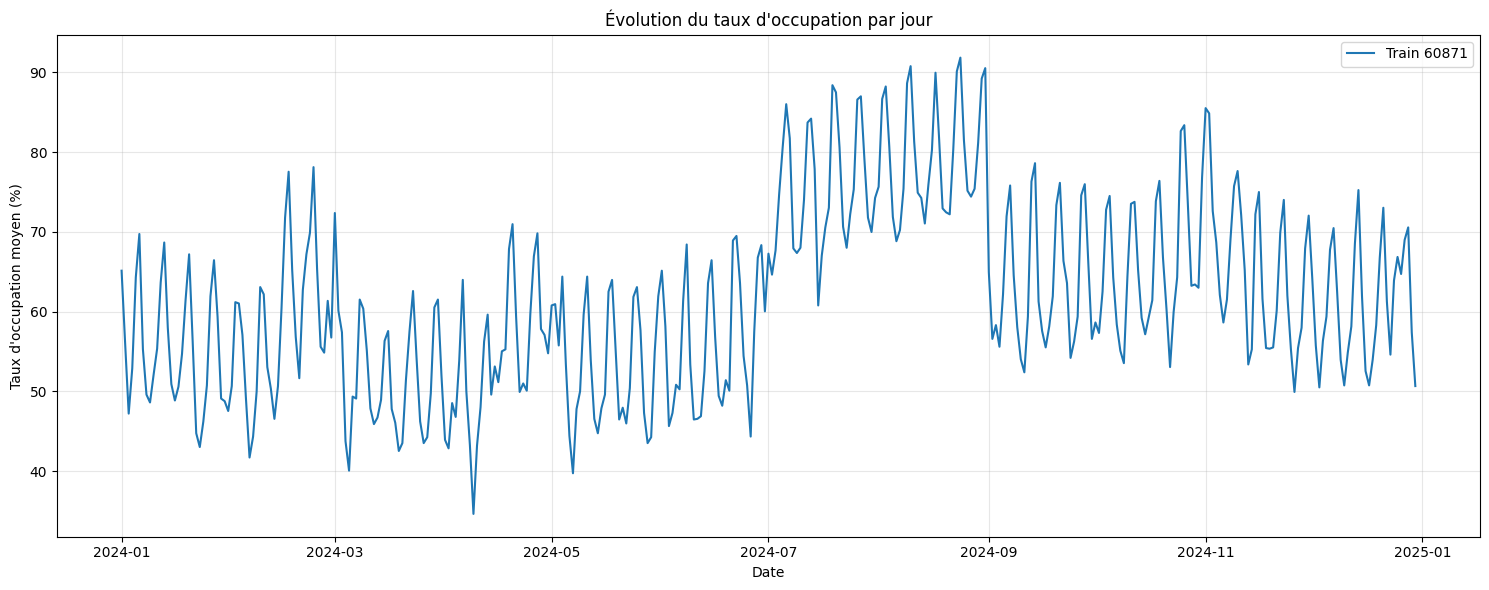

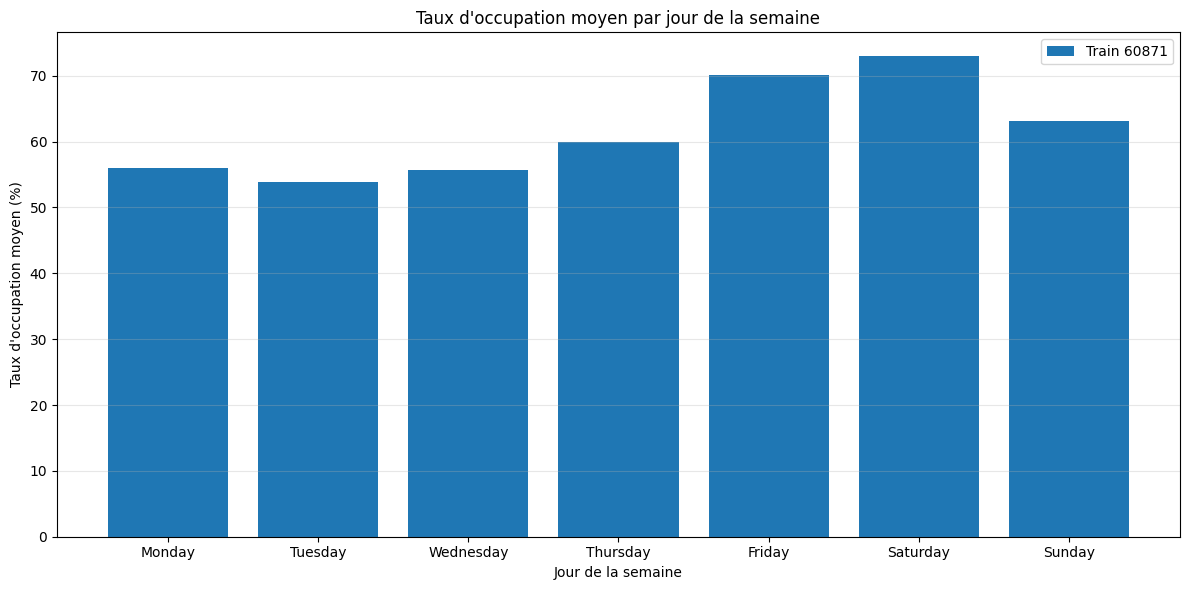

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (11,) and arg 1 with shape (12,).

Consolidation des données de train dans ./train_data
Trouvé 365 fichiers JSON à traiter
Traitement du fichier 1/365: 60871_2024-01-01.json
Traitement du fichier 11/365: 60871_2024-01-11.json
Traitement du fichier 21/365: 60871_2024-01-21.json
Traitement du fichier 31/365: 60871_2024-01-31.json
Traitement du fichier 41/365: 60871_2024-02-10.json
Traitement du fichier 51/365: 60871_2024-02-20.json
Traitement du fichier 61/365: 60871_2024-03-01.json
Traitement du fichier 71/365: 60871_2024-03-11.json
Traitement du fichier 81/365: 60871_2024-03-21.json
Traitement du fichier 91/365: 60871_2024-03-31.json
Traitement du fichier 101/365: 60871_2024-04-10.json
Traitement du fichier 111/365: 60871_2024-04-20.json
Traitement du fichier 121/365: 60871_2024-04-30.json
Traitement du fichier 131/365: 60871_2024-05-10.json
Traitement du fichier 141/365: 60871_2024-05-20.json
Traitement du fichier 151/365: 60871_2024-05-30.json
Traitement du fichier 161/365: 60871_2024-06-09.json
Traitement du fichier 

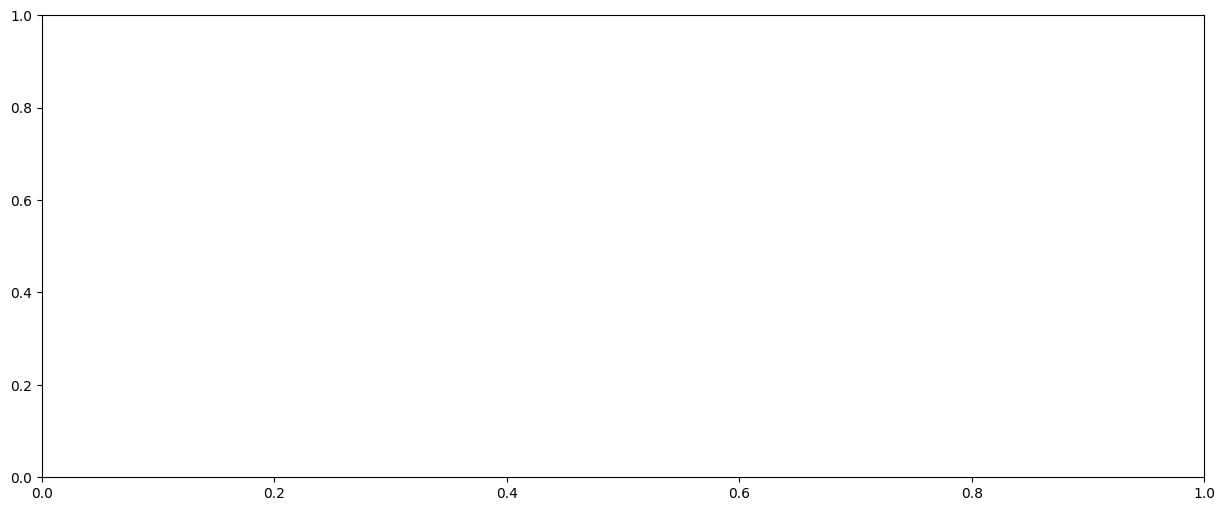

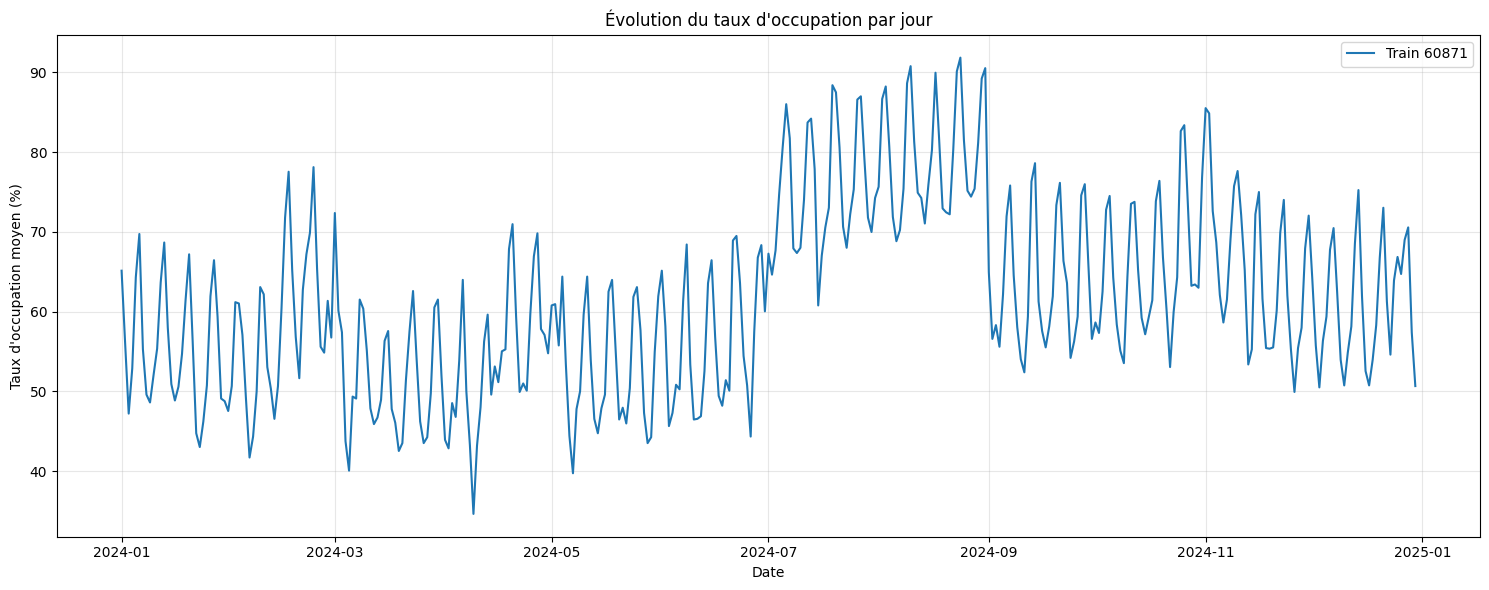

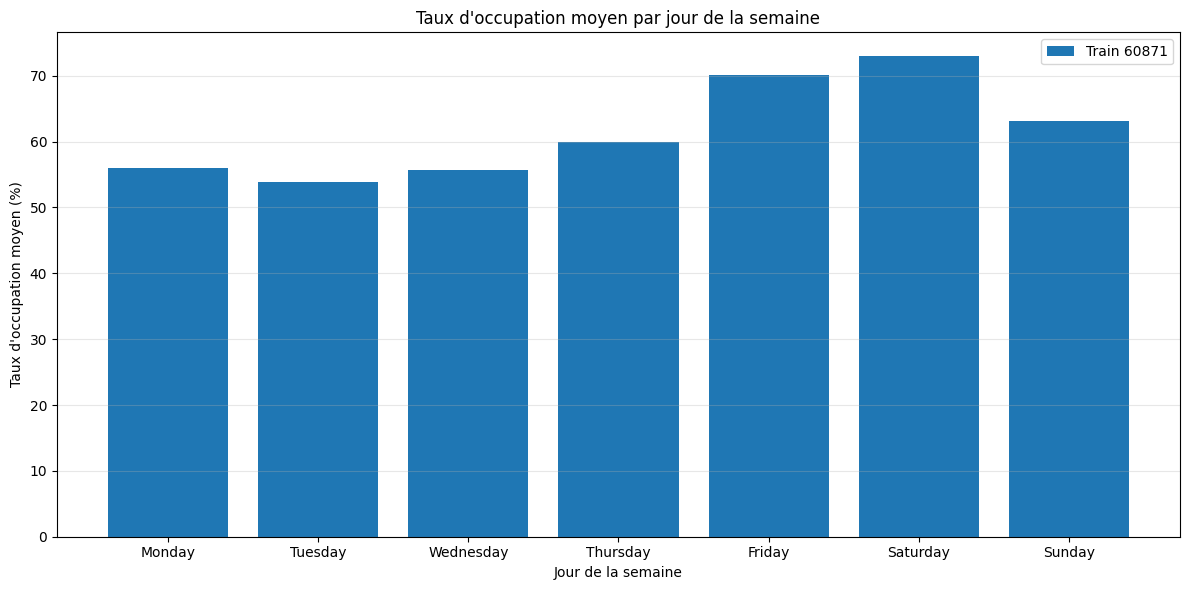

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (11,) and arg 1 with shape (12,).

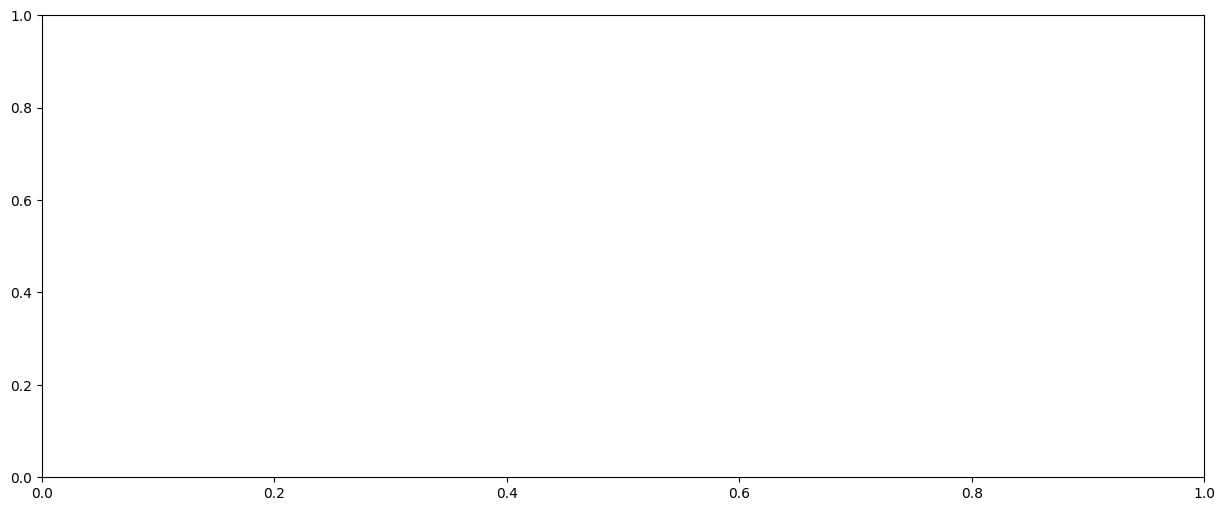

In [3]:
# Importer le script
%run json_to_csv_converter.py

# Convertir tous les fichiers JSON en un seul CSV
consolidated_file = consolidate_train_data_to_csv(
    input_folder="./train_data",     # Dossier contenant vos fichiers JSON
    output_file="./train_data.csv",  # Fichier CSV de sortie
    include_all_fields=False,        # Format résumé par jour/gare (plus compact)
    verbose=True                     # Afficher la progression
)

# Analyser les tendances d'occupation (facultatif)
stats = analyze_occupation_trends(
    csv_file=consolidated_file,
    output_folder="./graphiques",    # Dossier pour enregistrer les graphiques
    train_number=None                # Analyser tous les trains (ou spécifier un train)
)

In [4]:
import os
import json
import csv
import glob
import pandas as pd

def convert_raw_train_data_to_csv(input_folder, output_file, verbose=True):
    """
    Convertit tous les fichiers JSON des données de train en un seul fichier CSV,
    en préservant la structure brute des données.
    
    Args:
        input_folder: Dossier contenant les fichiers JSON des trains
        output_file: Chemin du fichier CSV de sortie
        verbose: Afficher les informations de progression
    
    Returns:
        str: Chemin du fichier CSV généré
    """
    if verbose:
        print(f"Conversion des données brutes de train depuis {input_folder}")
    
    # Exclure les fichiers non pertinents
    excluded_files = ["Référentiel_stations.json", "metadata.json"]
    
    # Lister tous les fichiers JSON
    json_files = []
    for file in glob.glob(os.path.join(input_folder, "*.json")):
        filename = os.path.basename(file)
        if filename not in excluded_files:
            json_files.append(file)
    
    if verbose:
        print(f"Trouvé {len(json_files)} fichiers JSON à traiter")
    
    # Préparer les données brutes
    all_raw_data = []
    
    # Traiter chaque fichier JSON
    for i, file_path in enumerate(json_files):
        if verbose and (i % 10 == 0 or i == len(json_files) - 1):
            print(f"Traitement du fichier {i+1}/{len(json_files)}: {os.path.basename(file_path)}")
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                train_data = json.load(f)
            
            # Extraire les informations de circulation
            train_number = train_data.get('circulation', {}).get('numero', '')
            journey_date = train_data.get('circulation', {}).get('date', '')
            
            # Traiter chaque siège dans chaque desserte
            for desserte in train_data.get('dessertes', []):
                desserte_code_uic = desserte.get('codeUIC', '')
                desserte_rang = desserte.get('rang', '')
                
                for rame in desserte.get('rames', []):
                    for voiture in rame.get('voitures', []):
                        coach_number = voiture.get('numero', '')
                        
                        for place in voiture.get('places', []):
                            seat_number = place.get('numero', '')
                            classe = place.get('classe', '')
                            compartiment = place.get('compartiment', '')
                            niveau = place.get('niveau', '')
                            type_place = place.get('type', '')
                            
                            # Informations d'occupation
                            occupation = place.get('occupation', {})
                            statut = occupation.get('statut', '')
                            flux_montant = 1 if occupation.get('fluxMontant', False) else 0
                            flux_descendant = 1 if occupation.get('fluxDescendant', False) else 0
                            
                            # Ajouter une ligne pour cette combinaison train/date/desserte/voiture/place
                            all_raw_data.append({
                                'train_number': train_number,
                                'journey_date': journey_date,
                                'desserte_code_uic': desserte_code_uic,
                                'desserte_rang': desserte_rang,
                                'coach_number': coach_number,
                                'seat_number': seat_number,
                                'classe': classe,
                                'compartiment': compartiment,
                                'niveau': niveau,
                                'type_place': type_place,
                                'statut': statut,
                                'flux_montant': flux_montant,
                                'flux_descendant': flux_descendant
                            })
        
        except Exception as e:
            if verbose:
                print(f"Erreur lors du traitement du fichier {file_path}: {e}")
    
    if not all_raw_data:
        print("Aucune donnée n'a été extraite des fichiers JSON.")
        return None
    
    # Convertir en DataFrame
    df = pd.DataFrame(all_raw_data)
    
    # Trier les données
    df = df.sort_values(by=['journey_date', 'desserte_rang', 'coach_number', 'seat_number'])
    
    # Enregistrer en CSV
    df.to_csv(output_file, index=False, encoding='utf-8')
    
    if verbose:
        print(f"Données brutes converties et enregistrées dans {output_file}")
        print(f"Nombre total de lignes: {len(df)}")
    
    return output_file

In [5]:
# Convertir tous les fichiers JSON en un seul CSV avec les données brutes
csv_file = convert_raw_train_data_to_csv(
    input_folder="./train_data",    # Dossier contenant vos fichiers JSON
    output_file="./raw_train_data.csv",  # Fichier CSV de sortie
    verbose=True
)

Conversion des données brutes de train depuis ./train_data
Trouvé 365 fichiers JSON à traiter
Traitement du fichier 1/365: 88442_2024-01-01.json
Traitement du fichier 11/365: 88442_2024-01-11.json
Traitement du fichier 21/365: 88442_2024-01-21.json
Traitement du fichier 31/365: 88442_2024-01-31.json
Traitement du fichier 41/365: 88442_2024-02-10.json
Traitement du fichier 51/365: 88442_2024-02-20.json
Traitement du fichier 61/365: 88442_2024-03-01.json
Traitement du fichier 71/365: 88442_2024-03-11.json
Traitement du fichier 81/365: 88442_2024-03-21.json
Traitement du fichier 91/365: 88442_2024-03-31.json
Traitement du fichier 101/365: 88442_2024-04-10.json
Traitement du fichier 111/365: 88442_2024-04-20.json
Traitement du fichier 121/365: 88442_2024-04-30.json
Traitement du fichier 131/365: 88442_2024-05-10.json
Traitement du fichier 141/365: 88442_2024-05-20.json
Traitement du fichier 151/365: 88442_2024-05-30.json
Traitement du fichier 161/365: 88442_2024-06-09.json
Traitement du fi